# Tensorflow CNN Multi-Category Image Classification

### Getting Started

Dataset:
- https://www.kaggle.com/datasets/puneet6060/intel-image-classification

### Normalize and Batch the Data

With Multi-label classification our `class_mode` changes to `categorical`

```
train_dir = 'seg_train/seg_train/'
test_dir = 'seg_test/seg_test/'

train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1./255)

train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical'
)

test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical'
)
```

Get the indices for each category

`test_data.class_indices`

### Model

The big change here is in the output Layer and compilation method

Output: The number units is the number of categories and the activation is `softmax`

Compilation: `loss` is now `categorical_crossentropy`


```
model_1 = Sequential()

model_1.add(Conv2D(128, 3, activation='relu', input_shape=(150,150,3)))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPool2D())

model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPool2D())

model_1.add(Flatten())

model_1.add(Dense(6, activation='softmax'))

model_1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)
```

### Predictions

```
y_true = []
preds = []

def predictor(path, image):

  # Get the full path of the image
  target = path + '/' + image

  # Get the category from the path name
  category = path.split('/')[2]

  # convert the image to a usable file to predict on
  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [150,150])
  
  # Rescale the image
  img = img/255.

  # Expand the dimensions
  img = tf.expand_dims(img, axis=0)

  # Make and save the prediction
  preds.append(np.argmax(model_1.predict(img), axis=1)[0])

  # Save the true label of the image based on the keys from the class_indices
  if category in test_data.class_indices.keys():
    y_true.append(test_data.class_indices[category])

# Predict on each file in the test folder categories
for dirs, fols, files in os.walk('seg_test'):
  if len(fols) < 1:
    for file in files:
      print(dirs, file)
      predictor(dirs, file)

```

In [1]:
###

### Import the Libraries

In [3]:
import pandas as pd
import numpy as np
import os
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimage
import zipfile
import tensorflow as tf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix, classification_report

# Import and Unzip the Dataset from Kaggle

Connect to Kaggle and then download the dataset

- https://stackoverflow.com/questions/56816537/cant-find-kaggle-json-file-in-google-colab

- Unzip the dataset

In [4]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"api-key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)

!chmod 600 ~/.kaggle/kaggle.json

In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification

 96% 332M/346M [00:01<00:00, 240MB/s]
100% 346M/346M [00:01<00:00, 209MB/s]


In [6]:
uz = zipfile.ZipFile('intel-image-classification.zip')
uz.extractall()
uz.close()

### Data Exploration

- How many different categories are there?
- How many files per category?
- How many files in total?
- What is the shape of the files?
- Plot a few images from random categories

In [7]:
folders = ['seg_train', 'seg_test', 'seg_pred']

for folder in folders:
  for dirs, fols, files in os.walk(folder):
    print(f'{dirs}, {fols}, {len(files)}')

seg_train, ['seg_train'], 0
seg_train/seg_train, ['sea', 'mountain', 'forest', 'buildings', 'glacier', 'street'], 0
seg_train/seg_train/sea, [], 2274
seg_train/seg_train/mountain, [], 2512
seg_train/seg_train/forest, [], 2271
seg_train/seg_train/buildings, [], 2191
seg_train/seg_train/glacier, [], 2404
seg_train/seg_train/street, [], 2382
seg_test, ['seg_test'], 0
seg_test/seg_test, ['sea', 'mountain', 'forest', 'buildings', 'glacier', 'street'], 0
seg_test/seg_test/sea, [], 510
seg_test/seg_test/mountain, [], 525
seg_test/seg_test/forest, [], 474
seg_test/seg_test/buildings, [], 437
seg_test/seg_test/glacier, [], 553
seg_test/seg_test/street, [], 501
seg_pred, ['seg_pred'], 0
seg_pred/seg_pred, [], 7301


(150, 150, 3)


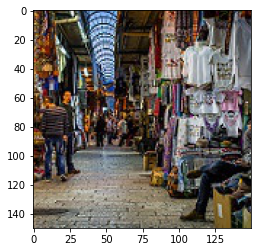

In [17]:
# Look at random images

path = 'seg_test/seg_test/'
category = 'street/'
target = path + category

image = random.choice(os.listdir(target))

img = mpimage.imread(target + image)
print(img.shape)
plt.imshow(img)


### Normalize and Batch the Data

- Rescale the Data

- Split the data into batches
- Class Mode: `categorical`
- Target Size: 150,150
- All other default values can remain

In [21]:
train_dir = 'seg_train/seg_train'
test_dir = 'seg_test/seg_test'

# Rescale images
train_data_gen = ImageDataGenerator(rescale=1./255)
test_data_gen = ImageDataGenerator(rescale=1.255)

train_data = train_data_gen.flow_from_directory(
    train_dir,
    target_size=(150,150),
    class_mode='categorical'
)


test_data = test_data_gen.flow_from_directory(
    test_dir,
    target_size=(150,150),
    class_mode='categorical'
)



Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [22]:
test_data.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}

### Model Creation

Create the model from the CNN Explainer
- https://poloclub.github.io/cnn-explainer/

For the final output layer
- Units: Number of categories
- Activation: `softmax`

Compile Layer Loss: `categorical_crossentropy`

Optional:
Build the model before fitting and explore the summary


In [23]:
model_1 = Sequential()

model_1.add(Conv2D(128, 3, activation='relu', input_shape=(150,150,3)))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPool2D())

model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(Conv2D(128, 3, activation='relu'))
model_1.add(MaxPool2D())

model_1.add(Flatten())

model_1.add(Dense(6, activation='softmax'))


model_1.compile(
    optimizer=Adam(),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

history_1 = model_1.fit(
    train_data,
    validation_data=test_data,
    epochs=5
)

Epoch 1/5
439/439 [==============================] - 95s 185ms/step - loss: 0.9452 - accuracy: 0.6310 - val_loss: 96.3790 - val_accuracy: 0.6163
Epoch 2/5
439/439 [==============================] - 79s 179ms/step - loss: 0.6237 - accuracy: 0.7734 - val_loss: 230.1671 - val_accuracy: 0.5140
Epoch 3/5
439/439 [==============================] - 79s 180ms/step - loss: 0.4634 - accuracy: 0.8380 - val_loss: 164.0645 - val_accuracy: 0.6317
Epoch 4/5
439/439 [==============================] - 79s 180ms/step - loss: 0.2910 - accuracy: 0.8991 - val_loss: 271.3399 - val_accuracy: 0.5670
Epoch 5/5
439/439 [==============================] - 79s 180ms/step - loss: 0.1674 - accuracy: 0.9460 - val_loss: 269.2469 - val_accuracy: 0.6937


### Model Analysis

Plot the Loss/Accuracy Curves

Was this over or under fit?

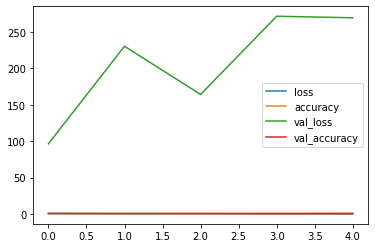

In [24]:
pd.DataFrame(history_1.history).plot()

In [27]:
def plot_losses(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  plt.plot(loss, label='loss')
  plt.plot(val_loss, label='val_loss')
  plt.title('Losses')
  plt.legend()

  plt.figure()
  plt.plot(accuracy, label='accuracy')
  plt.plot(val_accuracy, label='val_accuracy')
  plt.title('Accuracies')
  plt.legend()

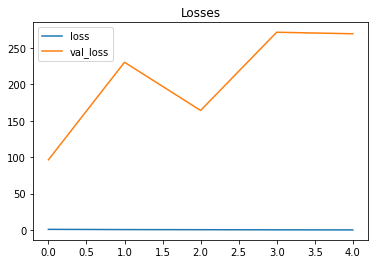

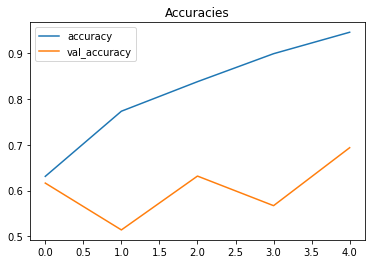

In [28]:
plot_losses(history_1)

### Run Predictions

- Run a prediction on a Single Image from the test set
- Run predictions on all images from the test set
 - Create a function
 - Save results in y_true and predictions
- Run y_test and predictions through the confusion_matrix and classification_report

In [29]:
model_1.evaluate(test_data)

94/94 [==============================] - 7s 70ms/step - loss: 269.2469 - accuracy: 0.6937


[269.24688720703125, 0.6936666369438171]

[0]


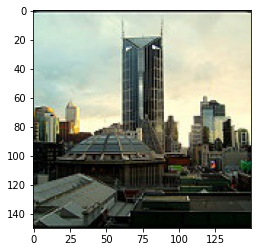

In [41]:
path = 'seg_test/seg_test/'
category = 'buildings/'

target = path + category

image = random.choice(os.listdir(target))

img_plot = mpimage.imread(target + image)
plt.imshow(img_plot)

img = tf.io.read_file(target + image)
img = tf.io.decode_image(img)
img = tf.image.resize(img, [150,150])
img = img/255.
img = tf.expand_dims(img, axis=0)
# print(img)

print(np.argmax(model_1.predict(img), axis=1))

In [43]:
y_true = []
predictions = []

def predictor(path, image):

  target = path + '/' + image

  print(target)

  img = tf.io.read_file(target)
  img = tf.io.decode_image(img)
  img = tf.image.resize(img, [150,150])
  img = img/255.
  img = tf.expand_dims(img, axis=0)
  # print(img)

  pred = np.argmax(model_1.predict(img), axis=1)
  predictions.append(pred[0])

  category = path.split('/')[2]

  if category in test_data.class_indices.keys():
    y_true.append(test_data.class_indices[category])



In [45]:
for dirs, fols, files in os.walk('seg_test'):
  if len(fols) < 1:
    for file in files:
      predictor(dirs, file)

seg_test/seg_test/sea/23213.jpg
seg_test/seg_test/sea/21224.jpg
seg_test/seg_test/sea/20077.jpg
seg_test/seg_test/sea/20769.jpg
seg_test/seg_test/sea/21022.jpg
seg_test/seg_test/sea/20811.jpg
seg_test/seg_test/sea/21940.jpg
seg_test/seg_test/sea/20171.jpg
seg_test/seg_test/sea/23069.jpg
seg_test/seg_test/sea/22337.jpg
seg_test/seg_test/sea/22374.jpg
seg_test/seg_test/sea/23342.jpg
seg_test/seg_test/sea/22736.jpg
seg_test/seg_test/sea/21624.jpg
seg_test/seg_test/sea/20342.jpg
seg_test/seg_test/sea/21462.jpg
seg_test/seg_test/sea/24076.jpg
seg_test/seg_test/sea/24027.jpg
seg_test/seg_test/sea/21456.jpg
seg_test/seg_test/sea/20124.jpg
seg_test/seg_test/sea/21476.jpg
seg_test/seg_test/sea/21393.jpg
seg_test/seg_test/sea/22154.jpg
seg_test/seg_test/sea/20678.jpg
seg_test/seg_test/sea/22849.jpg
seg_test/seg_test/sea/20148.jpg
seg_test/seg_test/sea/22012.jpg
seg_test/seg_test/sea/21012.jpg
seg_test/seg_test/sea/24187.jpg
seg_test/seg_test/sea/24301.jpg
seg_test/seg_test/sea/20530.jpg
seg_test

In [46]:
set(y_true), set(predictions)

({0, 1, 2, 3, 4, 5}, {0, 1, 2, 3, 4, 5})

In [47]:
len(y_true), len(predictions)

(3000, 3000)

In [48]:
print(confusion_matrix(y_true, predictions))
print(classification_report(y_true, predictions))

[[327   9   4   8  24  65]
 [  4 447   2   9   1  11]
 [  8   3 315 123  99   5]
 [  2   2  37 431  52   1]
 [  7   1  11  39 446   6]
 [ 61  23   3   7  14 393]]
              precision    recall  f1-score   support

           0       0.80      0.75      0.77       437
           1       0.92      0.94      0.93       474
           2       0.85      0.57      0.68       553
           3       0.70      0.82      0.75       525
           4       0.70      0.87      0.78       510
           5       0.82      0.78      0.80       501

    accuracy                           0.79      3000
   macro avg       0.80      0.79      0.79      3000
weighted avg       0.80      0.79      0.78      3000



In [49]:
test_data.class_indices

{'buildings': 0,
 'forest': 1,
 'glacier': 2,
 'mountain': 3,
 'sea': 4,
 'street': 5}